## Python statistics essential training - 04_04_testing

In [1]:
#meta 4/19/2020
#Ch4. Statistical Inference
#my code and solution code bits

In [2]:
import math
import io

In [3]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
import scipy.stats
import scipy.optimize
import scipy.spatial

# Statistical Inference

# Hypothesis testing
We go back to 1854 in London, a very rough time because of the repeated and deadly epidemics of cholera. Physician John Snow used simple statistics and beautiful plotting, to pinpoint the origin of one such outbreak to a contaminated water pump on Broad Street. We are going to follow in John Snow's footsteps to learn about testing hypotheses. So here are two datasets.

## 0. Load Data
The first dataset contains the positions of eight water pumps in Central London. These are given as latitude/longitude, and also distances from a reference point, pump number zero, in kilometers. The other dataset contains the number of deaths at different locations, as well as the closest pump to that location.


In [5]:
pumps = pd.read_csv('lynda_data/pumps.csv')
pumps

,lat,lon,x,y
0,51.513341,-0.136668,0.000000,0.000000
1,51.513876,-0.139586,-0.201858,0.059469
2,51.514906,-0.139671,-0.207738,0.173961
3,51.512354,-0.131630,0.348513,-0.109712
4,51.512139,-0.133594,0.212650,-0.133611
5,51.511542,-0.135919,0.051813,-0.199972
6,51.510019,-0.133962,0.187193,-0.369265
7,51.511295,-0.138199,-0.105910,-0.227428


In [6]:
cholera = pd.read_csv('lynda_data/cholera.csv')
#look at one record every 50
cholera[::50]

,deaths,lat,lon,x,y,closest
0,3,51.513418,-0.137930,-0.087301,0.008559,0
50,1,51.512447,-0.137656,-0.068347,-0.099375,0
100,4,51.512250,-0.135394,0.088131,-0.121273,5
150,2,51.513524,-0.134091,0.178269,0.020342,4
200,1,51.514586,-0.136030,0.044135,0.138391,0


## 1. Analyze
We can plot this quickly. We want the square figure, and a scatter plot of the pumps, and the deaths. 

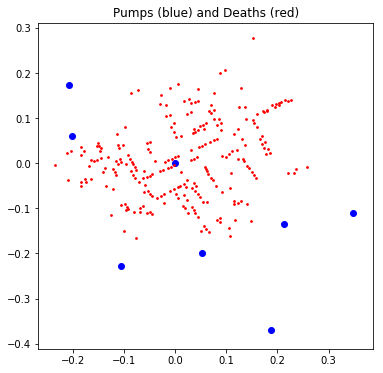

In [7]:
plt.figure(figsize=(6,6))
plt.scatter(pumps.x,pumps.y,color='b')
plt.scatter(cholera.x,cholera.y,color='r',s=3)
plt.title("Pumps (blue) and Deaths (red)")
plt.draw()

In fact, it would be fun to over-plot this on a map of London. I have obtained such a bitmap from Google Maps, using the central coordinates. So I load this with matplotlib. Now I can show the image using imshow, but I also need to know its size.

So Google Maps, I found out it's about 7.6 kilometers in both height and width. Now I can over-plot my pumps and unlucky addresses. 

In [8]:
img = matplotlib.image.imread('lynda_img/london.png')

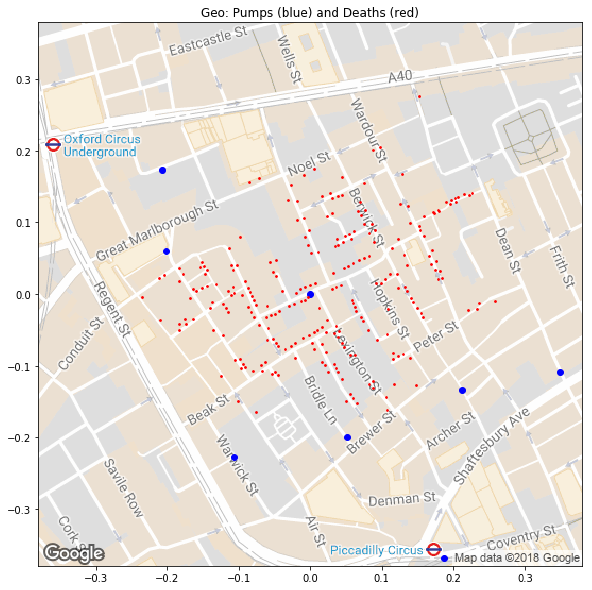

In [9]:
plt.figure(figsize=(10,10))

plt.imshow(img,extent=[-0.38,0.38,-0.38,0.38])

plt.scatter(pumps.x,pumps.y,color='b')
plt.scatter(cholera.x,cholera.y,color='r',s=3)
plt.title("Geo: Pumps (blue) and Deaths (red)")
plt.draw()

This map compares quite well with John Snow's original. In fact, the map seems already rather damning for the pump in the center, which is pump number zero.

#### Hypothesis Testing
So let's look at this. 

In [10]:
cholera.closest.value_counts()

0    171
1     36
4     19
5     13
7      9
2      2
Name: closest, dtype: int64

This is a tally of addresses, but we really need the total number of deaths closest to each pump. 

In [11]:
#group the data by the column closest, and then sum up the deaths. 
cholera.groupby('closest').deaths.sum()

closest
0    340
1     65
2      5
4     40
5     27
7     12
Name: deaths, dtype: int64

Okay, so there's no doubt. If deaths occur randomly in each area, there's no way we could get 340 in area zero and so few in all the others.

So to make the game more interesting statistically, we will assume that the populations of each area are very different, with many more people living in the area closest to pump zero. Thus, we do expect more deaths there. So let's make a simulation. We'll use only areas zero, one, four and five, which have the most cases of cholera, and simulate each death randomly, proportionally to the population of each area. I'll write the function for this.


In [12]:
#Enclose the results in a DataFrame and use numpy random.choice to select a number between 0,1,4,5, n times
#with probabilities proportional to populations in the areas. So 65%, 15%, and 10%. 
def simulate(n):
    return pd.DataFrame({'closest': np.random.choice([0,1,4,5],size=n,p=[0.65,0.15,0.10,0.10])})


In [13]:
#try this once for the total number of deaths, which is 489, closest.
simulate(489).closest.value_counts()

0    318
1     71
5     54
4     46
Name: closest, dtype: int64

So we get something close to what we actually observed in the true data. What we need now is the sampling distribution of the number of deaths in area zero. 

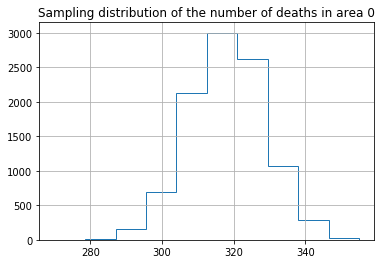

In [16]:
#extract the count for area zero, repeat the operation 10,000 times, and enclose the result in a DataFrame.
sampling = pd.DataFrame({'counts': [simulate(489).closest.value_counts()[0] for i in range(10000)]})
sampling.counts.hist(histtype='step')
plt.title("Sampling distribution of the number of deaths in area 0")
plt.draw()                        

We have generated this distribution under the null hypothesis that the pumps have nothing to do with cholera, and the deaths occur simply proportionally to population. We can now compare this distribution with the observed number of 340 deaths in area zero. More precisely, we evaluate at what quantile we find 340 in this null hypothesis sampling distribution.


In [17]:
#used scipy.stats.percentileofscore
print(scipy.stats.percentileofscore(sampling.counts, 340))
100 - scipy.stats.percentileofscore(sampling.counts, 340)

98.28


1.7199999999999989

So 340 is a very extreme value, which we would not expect from the null scenario. In fact, we'd expect it only 1.86 (1.72 here) percent of the time. This is known as the P value.
#### p-value
the smaller the P value, the more strongly we can reject the null hypothesis.  

I've just presented a very simple example of hypothesis testing. 
#### Null Hypothesis test  
- observe statistic in data  
- formulate hypotheses  
    - Ho: pump 0 has nothing to do with cholera  
    - Ha: it's the pump 0  
- compute sampling distribution of statistice under Ho  
- quantile of observed statistic gives p-value  

We have made an observation, many deaths in area zero. We have made a hypothesis - it's not the pump. And we have estimated the distribution of expected deaths under a null hypothesis. Last, we have verified how extreme our observed finding was with respect to the null distribution. Note that the only two permissible conclusions from a formal hypothesis test such as this is I reject the null hypothesis, or I failed to reject the null hypothesis.

This is a very formal way of reasoning, but it's the only one we can support firmly with statistics. 

Note about p-hacking: The scientific community has recently witnessed a harsh debate about the value of hypothesis testing, and especially about what P value should be required to make a conclusion. The problem is that if you select, say P of 0.05, five percent, but you make many tests, eventually you are going to find many where the null hypothesis is wrongly rejected, just by chance.

The lesson is that one must be careful about making conclusions, for instance, by requiring a lower P value or an established causal link, and not just apply a formula blindly.